In [278]:
"""
 Peak alignment between mass spectrum in the whole dataset 
"""
import os
import pandas as pd
import pickle
import biotype.similarity as sim

In [279]:
DATA_DIR_PATH = "datasets/export"
PEAK_DIR_PATH = "extracted_peaks"
files =  os.listdir(DATA_DIR_PATH)
files = [fn  for fn in files if fn.endswith(".txt")]
files = sorted(files)
files[:5]

['L100_0_G7_1.txt',
 'L100_0_G8_1.txt',
 'L101_0_A1_1.txt',
 'L101_0_A2_1.txt',
 'L102_0_A3_1.txt']

In [280]:
n = len(files)
all_peaks = [] # list of tuples (m/z, intensity, dataset_id) ordered by m/z value
for i in range(n):
    df = None
    df = pd.read_table(f"{DATA_DIR_PATH}/{files[i]}",sep=" ", header=None,names=['m/z', 'intensity']) 
    x, y = df['m/z'].to_numpy(), df['intensity'].to_numpy()

    pickle_file = files[i][:-4] # trim '.txt'
    with open(f'{PEAK_DIR_PATH}/{pickle_file}_peaks.pkl', 'rb') as peak_file:
        peaks = pickle.load(peak_file)
        # peaks_extracted +=  [(x[peaks], y[peaks])] 
        for p in peaks:
            all_peaks += [(x[p],y[p], i)]

all_peaks = sorted(all_peaks, key=lambda x: x[0])
all_mz = [mz for mz,pk,ms in all_peaks]
all_mz[:5]

[1000.748, 1000.748, 1000.871, 1000.871, 1000.948]

In [281]:
print(f"min={all_mz[0]}, max={all_mz[-1]}, N={len(all_mz)}")
mz_min, mz_max = all_mz[0], all_mz[-1]

min=1000.748, max=20073.668, N=20923


In [282]:
import pandas as pd
df = pd.DataFrame(all_peaks, columns=['mz', 'intensity', 'dataset_id'])
df.head()

,mz,intensity,dataset_id
0,1000.748,5652,42
1,1000.748,2899,90
2,1000.871,7600,93
3,1000.871,6380,95
4,1000.948,2654,100


In [283]:
df.tail()

,mz,intensity,dataset_id
20918,20070.254,284,47
20919,20070.681,481,7
20920,20071.480,1,0
20921,20071.961,264,61
20922,20073.668,246,82


<AxesSubplot:>

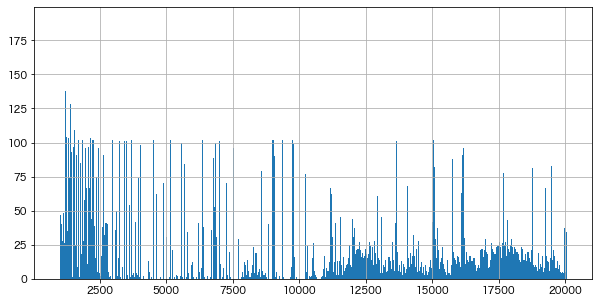

In [284]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5     
df['mz'].hist(bins=1000)

In [285]:
import itertools
""" Partition to groups not exceeding delta --> TO BE DELETED
"""
def grouper(iterable, delta=5):
    low = None
    group = []
    for item in iterable:
        if low is None or item - low <= delta:
            group.append(item)
            if low is None:
                low = item
        else:
            yield group
            group = [item]
            low = item
    if group:
        yield group

numbers = [123, 124, 128, 160, 167, 213, 215, 230, 245, 255, 257, 400, 401, 402, 430]
dict(enumerate(grouper(numbers, 15), 1))

{1: [123, 124, 128],
 2: [160, 167],
 3: [213, 215],
 4: [230, 245],
 5: [255, 257],
 6: [400, 401, 402],
 7: [430]}

# Algorithms
- algorithm 1 (segment): reccurisively divide data whenever gap > delta, w.r.t. step=1,2,...
- algorithm 2 (sequent_join): reccurisively join leftmost neighbors when span < epsilon
- algorithm 3 (nearest_join): reccurisively join nearest neighbors when span < epsilon 

# Parameters
- `data`: data to process
- `delta`: reject threshold, data with a gap wider than `delta` will be divided
- `epsilon`: accept threshold, neighbors close enough (`epsilon`) will be joined

In [286]:
def pairwise(iterable):
    """ generate pair of consequent items   
      [s0,s1,s2,s3] -> [(s0, s1), (s1, s2), (s2, s3)]
    """
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a,b)

print (list(pairwise([1,2,3,5,6])))

[(1, 2), (2, 3), (3, 5), (5, 6)]


In [287]:
def segment(data, delta=3):
    """ algorithm 1 (segment): reccurisively divide data whenever gap > delta, w.r.t. step=1,2,3,...
    """
    return exec_segment(data, [-1, len(data)-1], delta, 1)
        
def exec_segment(data, bins, delta, step):
    new_bins = bins[:]
    done = True
    for s, t in pairwise(bins):
        for i in range(s+1, t, step):
            j = i + step
            if j<=t and data[j] - data[i] > delta:
                new_bins += [j-1]
                done = False
                    
    bins = sorted(list(set(new_bins)))
    
    if done:
        return bins
    else:
        return exec_segment(data, bins, delta, step+1)
    

In [288]:
delta = 3
bins = segment(all_mz, delta)
print(bins[:10])
print(bins[-10:])

[-1, 32, 106, 120, 164, 167, 219, 220, 321, 344]
[20877, 20881, 20883, 20887, 20888, 20891, 20894, 20898, 20916, 20922]


In [289]:
for i, j in pairwise(bins):
    d = all_mz[j]-all_mz[i+1]
    print(f"[{all_mz[i+1]:.3f}, {all_mz[j]:.3f}]:{j-i:3d} {d:.3f} {'#BAD' if d>delta else 'y'}")

[1000.748, 1002.126]: 33 1.378 y
[1007.214, 1009.410]: 74 2.196 y
[1016.519, 1017.667]: 14 1.148 y
[1023.418, 1025.339]: 44 1.921 y
[1031.650, 1033.425]:  3 1.775 y
[1044.123, 1046.584]: 52 2.461 y
[1049.304, 1049.304]:  1 0.000 y
[1053.259, 1055.729]:101 2.470 y
[1061.848, 1064.815]: 23 2.967 y
[1064.883, 1066.382]: 12 1.499 y
[1073.961, 1076.301]:  4 2.340 y
[1076.990, 1078.074]:  6 1.084 y
[1085.871, 1088.245]: 36 2.374 y
[1088.938, 1088.938]:  1 0.000 y
[1092.803, 1092.803]:  1 0.000 y
[1095.958, 1098.471]: 26 2.513 y
[1114.818, 1117.741]: 35 2.923 y
[1118.544, 1118.544]:  1 0.000 y
[1122.461, 1125.265]:  3 2.804 y
[1125.970, 1128.904]: 32 2.934 y
[1129.005, 1130.921]: 32 1.916 y
[1146.305, 1149.157]: 17 2.852 y
[1149.463, 1149.971]:  3 0.508 y
[1151.193, 1151.193]:  1 0.000 y
[1151.396, 1153.332]: 28 1.936 y
[1158.228, 1158.228]:  2 0.000 y
[1164.875, 1168.463]:102 3.588 #BAD
[1173.905, 1176.891]:  3 2.986 y
[1178.333, 1180.391]: 17 2.058 y
[1187.205, 1188.756]:  6 1.551 y
[1192.1

[15846.540, 15848.056]:  3 1.516 y
[15849.951, 15853.039]:  3 3.088 #BAD
[15854.500, 15857.154]:  4 2.654 y
[15857.861, 15860.567]:  7 2.706 y
[15862.842, 15862.842]:  1 0.000 y
[15864.359, 15864.359]:  2 0.000 y
[15868.102, 15870.427]:  4 2.325 y
[15873.462, 15876.118]:  3 2.656 y
[15877.635, 15877.635]:  1 0.000 y
[15881.429, 15883.327]:  2 1.898 y
[15884.465, 15885.224]:  2 0.759 y
[15888.260, 15890.028]:  3 1.768 y
[15892.815, 15892.815]:  1 0.000 y
[15893.194, 15895.050]:  4 1.856 y
[15896.231, 15897.750]:  6 1.519 y
[15902.306, 15904.204]:  2 1.898 y
[15908.443, 15908.443]:  1 0.000 y
[15912.559, 15914.801]:  3 2.242 y
[15921.676, 15924.596]:  3 2.920 y
[15925.160, 15928.135]:  4 2.975 y
[15928.516, 15928.516]:  1 0.000 y
[15931.176, 15931.936]:  3 0.760 y
[15936.497, 15939.467]:  2 2.970 y
[15940.678, 15942.959]:  3 2.281 y
[15944.450, 15944.450]:  1 0.000 y
[15946.381, 15948.633]:  4 2.252 y
[15952.465, 15952.845]:  2 0.380 y
[15956.268, 15957.790]:  5 1.522 y
[15959.692, 15959

In [290]:
def sequent_join(data, delta=5, epsilon=1):
    """ algorithm 2 (sequent_join): reccurisively join leftmost neighbors when span < epsilon
    """
    bins = [[v] for v in data]
    
    for d in reversed(range(11)):
        new_bins = []
        i, e = 0, epsilon/2**d
        while i < len(bins):
            if i == len(bins)-1:
                new_bins += [bins[i]]
                break

            a, b = bins[i], bins[i+1]
            if max(b) - min(a) < e: # |span{a, b}|< e
                new_bins += [a+b]
                i += 2
            else:
                new_bins += [a]
                i += 1
            
        bins = new_bins[:]
        
    return bins


In [292]:
delta, epsilon =5, 3
bins = sequent_join(all_mz, delta, epsilon)
ob = 0
for x in bins:
    d = max(x) - min(x)
    ok = '' if d <= min(x)-ob else '#BAD' 
    ob = max(x)
    print(f"[{min(x):.3f},{max(x):.3f}] {len(x):3d} d={max(x)-min(x):.3f} {'y' if max(x)-min(x)<=epsilon else '*'} {ok}")

[1000.748,1002.126]  33 d=1.378 y 
[1007.214,1009.410]  74 d=2.196 y 
[1016.519,1017.667]  14 d=1.148 y 
[1023.418,1025.339]  44 d=1.921 y 
[1031.650,1033.425]   3 d=1.775 y 
[1044.123,1046.584]  52 d=2.461 y 
[1049.304,1049.304]   1 d=0.000 y 
[1053.259,1055.729] 101 d=2.470 y 
[1061.848,1064.619]  19 d=2.771 y 
[1064.717,1066.382]  16 d=1.665 y #BAD
[1073.961,1076.301]   4 d=2.340 y 
[1076.990,1078.074]   6 d=1.084 y #BAD
[1085.871,1087.651]  30 d=1.780 y 
[1088.013,1088.938]   7 d=0.925 y #BAD
[1092.803,1092.803]   1 d=0.000 y 
[1095.958,1098.471]  26 d=2.513 y 
[1114.818,1116.939]  34 d=2.121 y 
[1117.741,1118.544]   2 d=0.803 y #BAD
[1122.461,1125.265]   3 d=2.804 y 
[1125.970,1127.694]  18 d=1.724 y #BAD
[1127.795,1129.711]  32 d=1.916 y #BAD
[1129.912,1130.921]  14 d=1.009 y #BAD
[1146.305,1147.488]  15 d=1.183 y 
[1148.344,1149.971]   5 d=1.627 y #BAD
[1151.193,1153.332]  29 d=2.139 y #BAD
[1158.228,1158.228]   2 d=0.000 y 
[1164.875,1166.720]  75 d=1.845 y 
[1166.777,1168.463]

[15634.999,15637.258]   3 d=2.259 y 
[15644.413,15646.296]   3 d=1.883 y 
[15648.179,15648.179]   1 d=0.000 y 
[15657.973,15659.480]   2 d=1.507 y 
[15662.871,15665.165]   2 d=2.294 y 
[15670.408,15670.408]   1 d=0.000 y 
[15680.032,15680.032]   1 d=0.000 y 
[15683.226,15683.226]   1 d=0.000 y 
[15694.728,15697.088]   3 d=2.360 y 
[15709.631,15710.008]   2 d=0.377 y 
[15714.537,15716.802]   2 d=2.265 y 
[15720.577,15720.577]   1 d=0.000 y 
[15727.413,15728.505]   2 d=1.092 y 
[15732.659,15734.925]   2 d=2.266 y 
[15736.814,15738.243]   3 d=1.429 y 
[15741.644,15743.991]   3 d=2.347 y 
[15745.880,15746.258]   2 d=0.378 y 
[15747.997,15748.903]   3 d=0.906 y 
[15750.079,15751.170]   2 d=1.091 y 
[15751.926,15753.815]   9 d=1.889 y #BAD
[15756.083,15757.216]   5 d=1.133 y 
[15757.896,15759.106]   5 d=1.210 y #BAD
[15761.677,15762.718]   2 d=1.041 y 
[15769.359,15772.338]   4 d=2.979 y 
[15773.473,15776.120]  23 d=2.647 y #BAD
[15776.498,15779.145]  50 d=2.647 y #BAD
[15779.361,15781.793] 

In [276]:
from decimal import *

def nearest_join(data, delta, epsilon): 
    """algorithm 3 (nearest_join): 
    reccurisively join nearest neighbors when span < epsilon 
    """
    sorted_uniques = sorted(list(set(data)))
    bins = [[v] for v in sorted_uniques]
    n = len(bins)
    gaps = [(round(min(bins[i+1])-max(bins[i]), 3), i) for i in range(n-1)]
    sorted_gaps = sorted(gaps)

    return bins, sorted_gaps

    
delta, epsilon = 5, 3
bins, gaps = nearest_join(all_mz, delta, epsilon)

for x in bins[:10]:
     print(x)
print("#" * 30)

for x in gaps[:10]:
     print(f"{x[0]},{x[1]:5d}")


[1000.748]
[1000.871]
[1000.948]
[1001.081]
[1001.083]
[1001.273]
[1001.366]
[1001.461]
[1001.556]
[1001.651]
##############################
0.001,  865
0.001, 1068
0.001, 1233
0.001, 1247
0.001, 1677
0.001, 1868
0.001, 1912
0.001, 2730
0.001, 3225
0.001, 3356
